# Simple workflow for an Employee Onboarding Process

In [ ]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

In [ ]:
# Define the state schema for the onboarding process
# Any dictionary of this type should have the following keys with their respective value types:
class OnboardingState(TypedDict):
    employee_name: str
    role: str
    equipment_assigned: bool
    orientation_scheduled: bool

In [ ]:
# Function to collect employee information
def collect_employee_info(state: OnboardingState) -> OnboardingState:
    print(f"Collecting information for {state['employee_name']} in role {state['role']}.")
    return state


In [ ]:
# Function to assign equipment based on role
def assign_equipment(state: OnboardingState) -> OnboardingState:
    if state['role'].lower() in ['developer', 'designer']:
        state['equipment_assigned'] = True
        print(f"Assigned equipment to {state['employee_name']}.")
    else:
        state['equipment_assigned'] = False
        print(f"No equipment needed for {state['employee_name']}.")
    return state

In [ ]:
# Function to schedule orientation
def schedule_orientation(state: OnboardingState) -> OnboardingState:
    state['orientation_scheduled'] = True
    print(f"Orientation scheduled for {state['employee_name']}.")
    return state


In [ ]:
# Initialize the StateGraph with the OnboardingState
graph = StateGraph(OnboardingState)

# Add nodes to the graph
graph.add_node("collect_info", collect_employee_info)
graph.add_node("assign_equipment", assign_equipment)
graph.add_node("schedule_orientation", schedule_orientation)

# Define the workflow by adding edges
graph.add_edge(START, "collect_info")
graph.add_edge("collect_info", "assign_equipment")
graph.add_edge("assign_equipment", "schedule_orientation")
graph.add_edge("schedule_orientation", END)

# Set the entry point for the graph
graph.set_entry_point("collect_info")

# Compile the graph into a runnable
runnable = graph.compile()

In [ ]:
# Visualize the workflow (requires graphviz)
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

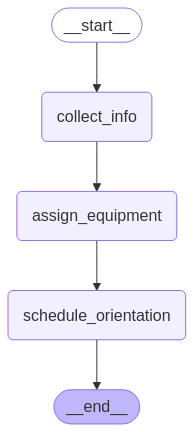

In [ ]:
display(
    Image(
        runnable.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
# Example invocation of the workflow
initial_state = {
    "employee_name": "Aarya Naik",
    "role": "Web Developer",
    "equipment_assigned": False,
    "orientation_scheduled": False
}

runnable.invoke(initial_state)

No equipment needed for Aarya Naik.
Orientation scheduled for Aarya Naik.


{'employee_name': 'Aarya Naik',
 'role': 'Web Developer',
 'equipment_assigned': False,
 'orientation_scheduled': True}

In [ ]:
# Example invocation of the workflow
initial_state = {
    "employee_name": "Bhavya Singh",
    "role": "Developer",
    "equipment_assigned": False,
    "orientation_scheduled": False
}

runnable.invoke(initial_state)

Assigned equipment to Bhavya Singh.
Orientation scheduled for Bhavya Singh.


{'employee_name': 'Bhavya Singh',
 'role': 'Developer',
 'equipment_assigned': True,
 'orientation_scheduled': True}

# AI based HR Policy Assistant

In [58]:
!pip install langchain-openai python-dotenv

In [77]:
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI

In [78]:
from google.colab import userdata
# Retrieve the API key from Colab's secrets
api_key = userdata.get('OPENAI_API_KEY')

In [79]:
# 1. Define policy documents as an in-memory dictionary
policy_documents = {
    "leave_policy": "Employees are entitled to 20 paid leave days per year. Additional unpaid leave can be requested with manager approval.",
    "work_hours": "Regular work hours are from 9 AM to 6 PM, Monday to Friday. Flexible work hours are allowed with prior approval.",
    "remote_work": "Employees can work remotely up to 3 days a week. Full remote work requires special approval.",
}

In [80]:
# 2. Simple retriever based on keywords
def extract_policy(state):
    question = state["question"].lower()
    context = ""

    if "leave" in question:
        context = policy_documents["leave_policy"]
    elif "work hours" in question or "timing" in question:
        context = policy_documents["work_hours"]
    elif "remote" in question or "work from home" in question:
        context = policy_documents["remote_work"]
    else:
        context = "I'm sorry, I couldn't find a matching policy."

    return {"question": state["question"], "context": context}

In [81]:
llm = ChatOpenAI(model="gpt-4o-mini", openai_api_key=api_key)

In [82]:
def generate_response(state):
    # Prepare the prompt with context and question
    prompt = f"Context: {state['context']}\nQuestion: {state['question']}\nAnswer concisely based on the provided context."

    # Generate response using the LLM
    response = llm.invoke(prompt)

    return {"question": state["question"], "context": state["context"], "response": response.content}

In [83]:
# 4. Build LangGraph with retriever and responder
builder = StateGraph(dict)
builder.add_node("PolicySearch", extract_policy)
builder.add_node("Response", generate_response)

builder.set_entry_point("PolicySearch")
builder.add_edge("PolicySearch", "Response")
builder.add_edge("Response", END)

graph = builder.compile()


In [84]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

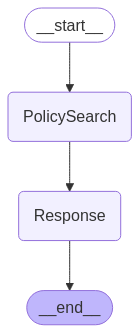

In [85]:
# Visualize using Mermaid
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [87]:
# 5. Example usage
question = "can we do work from home?"
result = graph.invoke({"question": question})
print(result["response"])


Yes, you can work from home up to 3 days a week. Full remote work requires special approval.
